# Preprocessing EEG data
In the last tutorial, we have seen that the raw data is hardly readable as contaminated by various artifacts. In this tutorial, we implement some methods to denoise EEG data, using the same data files as last time.

In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

## Import data
Follow the tutorial from last week to import the raw data files in a `eegdata` variable. No need to epoch yet: for the reasons mentionned in the associated lecture, it is better to apply the first preprocessing steps on the full recording sequence. Visualize once again the PSD.

In [2]:
datapath = "D:/PhD/EEG data/face is left button_instructions/participant 115/115_bloc_1.vhdr"
eegdata = mne.io.read_raw_brainvision(datapath,preload=True)

Extracting parameters from D:/PhD/EEG data/face is left button_instructions/participant 115/115_bloc_1.vhdr...
Setting channel info structure...
Reading 0 ... 350839  =      0.000 ...   350.839 secs...


# Filter data
Apply a 3-35Hz bandpass filter to the raw data (use the method `eegdata.filter($f_{low}$,$f_{high}$)`) and look how the PSD changed. What do you notice?

Try changing some of the parameters of the filter (refer to the documentation), and in particular the method and the phase of the filter. Compare the performances: advantage of each method, drawbacks. Take into account the computation time too.

In [3]:
eegdata.filter(3.,35.,)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1651 samples (1.651 sec)



<RawBrainVision | 115_bloc_1.eeg, 32 x 350840 (350.8 s), ~85.7 MB, data loaded>

## Epoching
Extract epochs between -0.5 to 2 seconds from the stimulus (markers `10` and `20`).

In [4]:
event_id=[10,20]

events, event_dict = mne.events_from_annotations(eegdata)
evt_ix=np.where(events[:,2]==event_id[0])
for ix in range(1,len(event_id)):
    evt_ix=np.hstack((evt_ix, np.where(events[:,2]==event_id[ix])))
stim_events=np.squeeze(events[evt_ix])
stim_events=np.sort(stim_events.view('int,int,int'), order=['f1'], axis=0).view(np.int)


ep=mne.Epochs(eegdata, stim_events, event_id, tmin=- 0.5, tmax=2, baseline=None, preload=True)

Used Annotations descriptions: ['Comment/actiCAP Data On', 'New Segment/', 'Stimulus/S 10', 'Stimulus/S 20', 'Stimulus/S 33', 'Stimulus/S 43', 'Stimulus/S 53', 'Stimulus/S110', 'Stimulus/S111', 'Stimulus/S120', 'Stimulus/S121', 'Stimulus/S124']
Not setting metadata
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Loading data for 60 events and 2501 original time points ...
0 bad epochs dropped


## Channel rejection and interpolation
Look into the data if there are channels that disfunctionned.

In [5]:
#ep.plot(block=True,scalings='auto')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reject and interpolate channels Fp1, Fp2 and T8:
- List in `ep.info['bads']` the names of these two channels
- Use the `mne.pick_types()` function to reject the bad channels. Set the parameter `exclude` to __[ ]__
- Interpolate these channels with the method `.interpolate_bads(reset_bads=False)`

Before the interpolation, you will need to add the montage, which gives the electrode locations. Since we did not measure them during our recordings, we simply use a template that is provided: the standard 10-20 montage.

In [19]:
montage1020 = mne.channels.make_standard_montage('standard_1020')
ep= ep.set_montage(montage1020)
ep.info['bads'] = ['Fp1','Fp2', 'T8']
ep.pick_types(eeg=True, exclude=[])
print(ep.info)
ep.interpolate_bads(reset_bads=False)

<Info | 9 non-empty values
 bads: 3 items (Fp1, Fp2, T8)
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 3.0 Hz
 lowpass: 35.0 Hz
 meas_date: 2019-05-27 13:47:22 UTC
 nchan: 32
 projs: []
 sfreq: 1000.0 Hz
>
Interpolating bad channels
    Automatic origin fit: head of radius 92.9 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 3 sensors


<Epochs |  60 events (all good), -0.5 - 2 sec, baseline off, ~36.7 MB, data loaded,
 '10': 32
 '20': 28>

Visualize again the epochs and look at what has changed.

In [14]:
#ep.plot()

## Epoch rejection
[The tutorial provided by MNE](https://mne.tools/stable/auto_tutorials/preprocessing/plot_20_rejecting_bad_data.html#sphx-glr-auto-tutorials-preprocessing-plot-20-rejecting-bad-data-py)  is very well written for visual inspection-based epoch rejection. You can explore also the `autoreject` package.

For epoch rejection based on thresholding: use the `.drop_bad()`method (beware to perform this on a copy of the ep object, and not on ep directly as this action is irreversible). Tune the threshold so that up to 10% of epochs are rejected.

In [20]:
reject = dict(eeg=90e-6)
ep_clean=ep.copy()
ep_clean.drop_bad(reject=reject)

    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F7', 'F8', 'TP10']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['CP5']
5 bad epochs dropped


<Epochs |  55 events (all good), -0.5 - 2 sec, baseline off, ~33.7 MB, data loaded,
 '10': 30
 '20': 25>

## ICA
We have learned that ICA splits the signal into independent sources. It is helpful to identify remaining EOG artifacts and the heartbeat.
Since we have rejected 3 channels, we can only extract $32-3=29$ independent components.
Create the ICA object using `mne.preprocessing.ICA()`, then fit it to the cleaned epoch struct (`ica.fit(cleaned_epochs)`).

In [21]:
ica=mne.preprocessing.ICA(n_components=29, random_state=42)
ica.fit(ep_clean)

Fitting ICA to data using 29 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 29 components
Fitting ICA took 5.8s.


<ICA | epochs decomposition, fit (fastica): 137555 samples, 29 components, channels used: "eeg">

Visualize the time series of the components using the `ica.plot_sources(epochs, show_scrollbars=False)` method

In [22]:
ica.plot_sources(ep_clean, show_scrollbars=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

By now you may be able to identify components that are clearly related to heart beat.

Now we introduce a new form of plots: the __topoplots__. They represent activity on a projection of the head shape. These will be particularly useful to look at activities at precise times or in frequency bands, as we will see in the next tutorials. For now, they will help us understand how the ICs have been built, that is, which combination of channels makes the given components. This can be done using `ica.plot_components()`

<IPython.core.display.Javascript object>


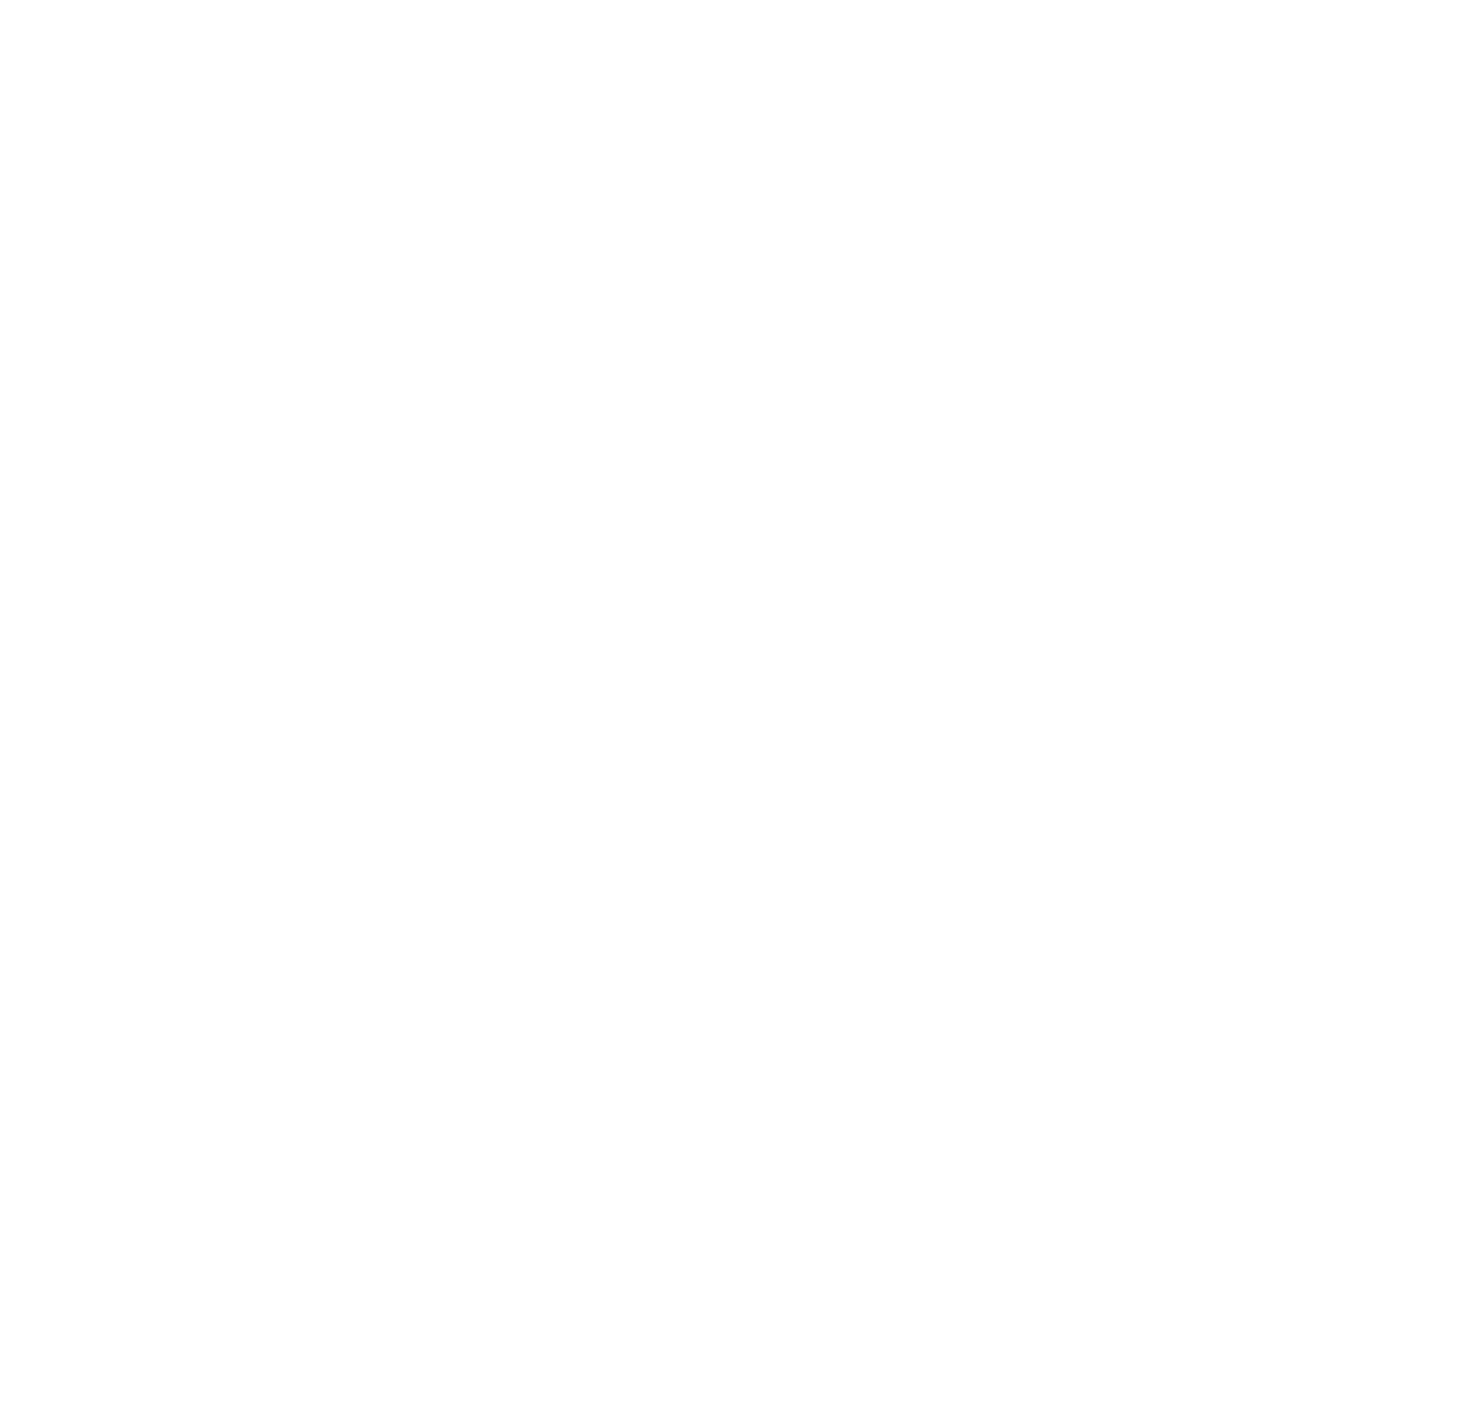

<IPython.core.display.Javascript object>


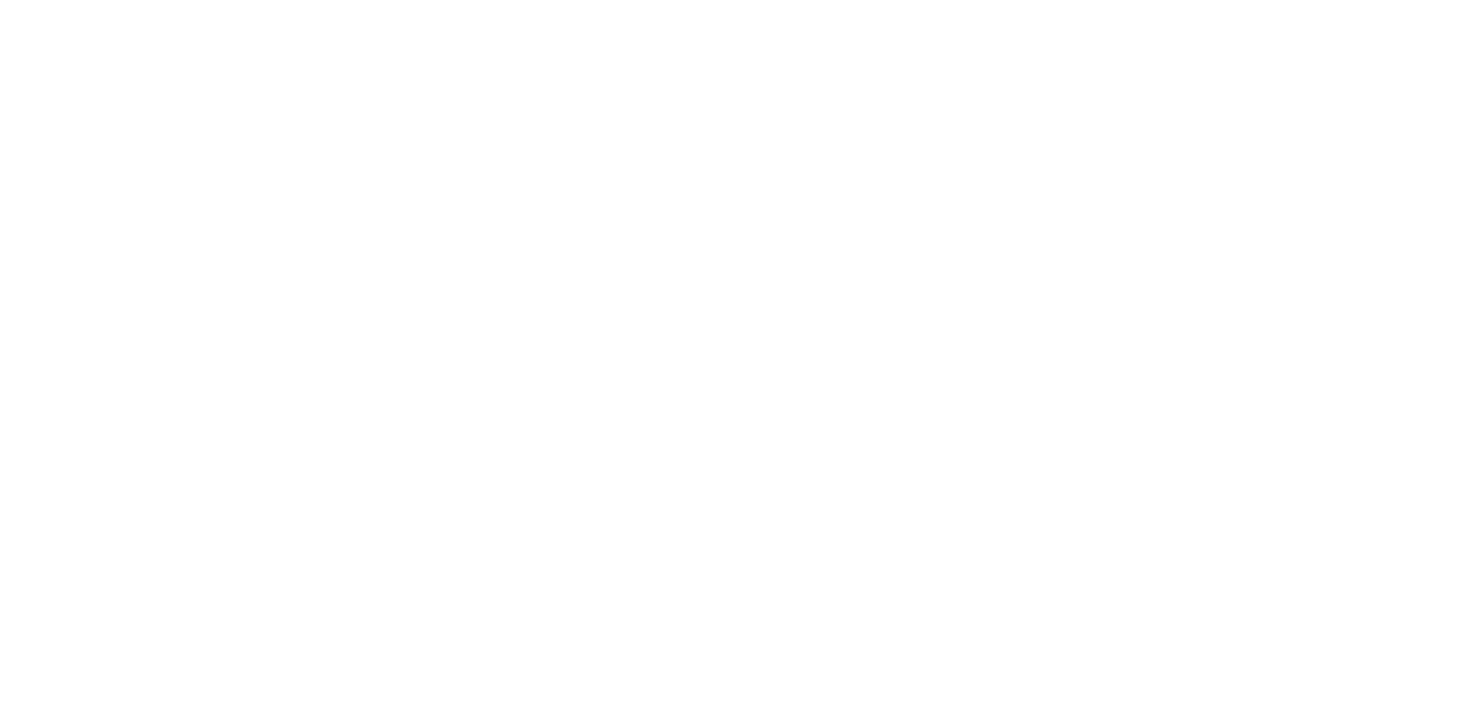

[<Figure size 975x942 with 20 Axes>, <Figure size 975x471 with 9 Axes>]

In [24]:
ica.plot_components()

Now you have identifies components that you want to exclude (namely: those showing ECG and EOG activity). To exclude these components: 
- List the indices to reject, and run `ica.exclude = [list of indices]`
- Apply the new transform to the epochs data (don't forget to make a copy as this is irreversible), using `ica.apply()`

In [25]:
ica.exclude = [0, 1]
ep_clean_ica = ep_clean.copy()
ica.apply(ep_clean_ica)

Transforming to ICA space (29 components)
Zeroing out 2 ICA components


<Epochs |  55 events (all good), -0.5 - 2 sec, baseline off, ~33.7 MB, data loaded,
 '10': 30
 '20': 25>

Now the data should be cleaner. Have a look at what it looks like! For easier representation, average epochs and look at what we obtain.
`evoked = epochs.average()`

<IPython.core.display.Javascript object>


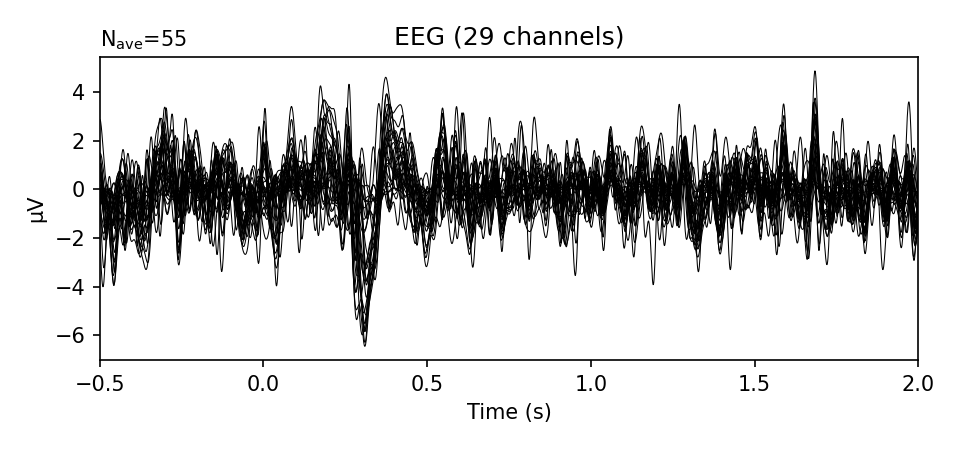

<IPython.core.display.Javascript object>


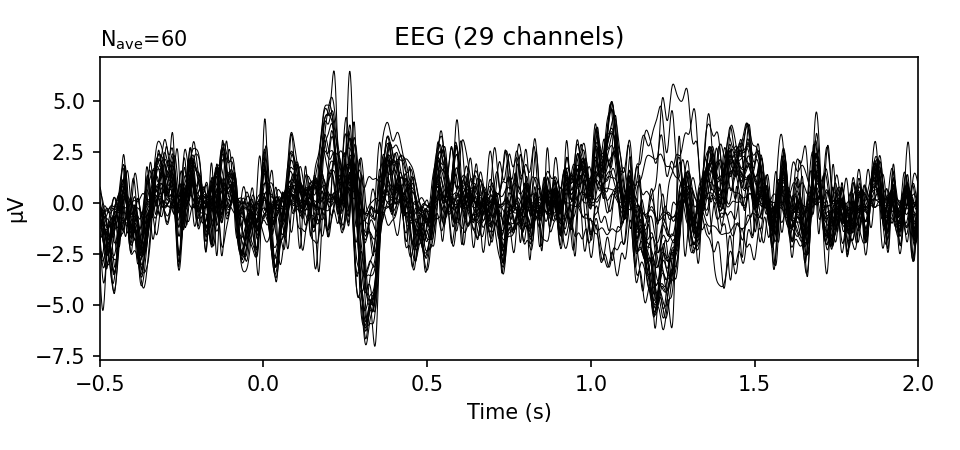

<IPython.core.display.Javascript object>


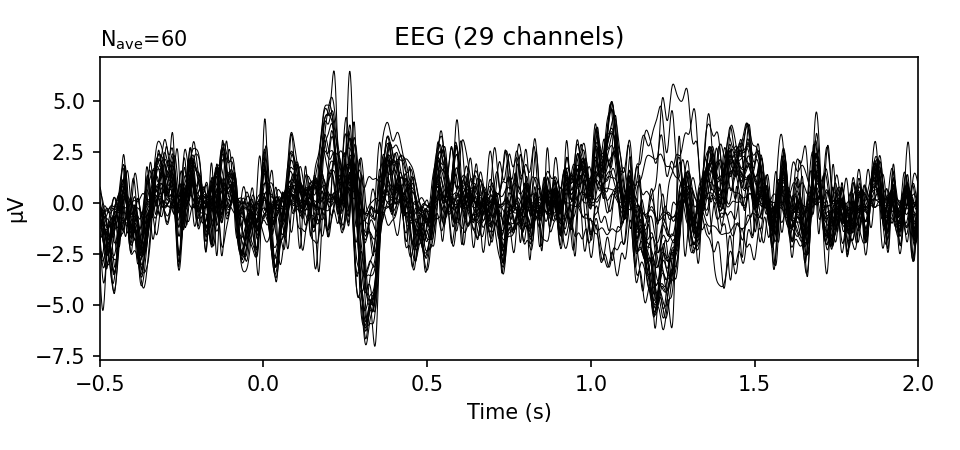

In [28]:
evoked_clean = ep_clean_ica.average()
evoked_clean.plot()

evoked=ep.average()
evoked.plot()